In [1]:
import gc
import os
from itertools import islice

from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import torch
from transformers import pipeline, CLIPModel, CLIPProcessor
from tqdm import tqdm

# Configuration
LOADER_PATCH_SIZE = 32
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Cuda Availability:{torch.cuda.is_available()} Training on {device}")

Cuda Availability:True Training on cuda


# Notebook for interactive testing for CLIP

In [2]:

class Cfg:
    model_id: str = "openai/clip-vit-base-patch32"
    batch_size: int = 32
    epochs: int = 40
    seed:   int = 42

    # -------- Optim & Loss ----------
    lr_head: float = 1e-3      # 线性头
    wd_head: float = 1e-4
    lr_lora: float = 1e-4      # LoRA 注入层
    wd_lora: float = 1e-2
    lambda_text: float = 0.3   # 文本对齐辅助损失权重

    early_stopping: bool = True
    early_stop_patience = 3
    early_stop_minimum_improvement:float = 0.02


    # -------- LoRA ----------
    lora_rank: int = 8
    lora_alpha: int = 16
    lora_dropout: float = 0.0
    lora_target: tuple = ("q_proj","k_proj","v_proj","out_proj")  # 只对注意力投影层做LoRA
    # 也可扩展到 MLP 内部 proj，但注意稳定性

    amp: bool = True

cfg = Cfg()

PREPROCESS_DATA_ROOT = "data/preprocessed"
torch.manual_seed(cfg.seed)
model_id = "openai/clip-vit-base-patch32"
clip_model = CLIPModel.from_pretrained(model_id).to(device).eval()
processor  = CLIPProcessor.from_pretrained(model_id)

/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json: 0.00B [00:00, ?B/s]

pytorch_model.bin:   0%|          | 0.00/605M [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/605M [00:00<?, ?B/s]

Using a slow image processor as `use_fast` is unset and a slow processor was saved with this model. `use_fast=True` will be the default behavior in v4.52, even if the model was saved with a slow processor. This will result in minor differences in outputs. You'll still be able to use a slow processor with `use_fast=False`.


preprocessor_config.json:   0%|          | 0.00/316 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/592 [00:00<?, ?B/s]

vocab.json: 0.00B [00:00, ?B/s]

merges.txt: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/389 [00:00<?, ?B/s]

In [3]:
# ---------- 2. Load Dataset ----------
def collate_pil(batch):
    # batch: List[ (PIL.Image.Image, int) ]
    images, labels = zip(*batch)           # images: tuple of PIL, labels: tuple of int
    return list(images), torch.tensor(labels)  # 让 processor 接收 list[PIL]，labels 变成 LongTensor

def preprocess_dataset(split="train",data_root='data',outputdir="data/preprocessed",batchsize=cfg.batch_size,fp16=False):
    os.makedirs(outputdir,exist_ok=True)
    dataset = datasets.Flowers102(root=data_root, split=split, download=True)
    classes = dataset.classes
    loader = DataLoader(dataset, batch_size=batchsize, shuffle= True if split=="train" else False, num_workers=0,collate_fn=collate_pil)

    # Allocate RAM
    N = len(dataset)
    C, H, W = 3, 224, 224
    pixels = torch.empty((N,C,H,W), dtype=torch.float32 if not fp16 else torch.float16)
    labels = torch.empty(N, dtype=torch.long)

    print(f"Preprocessing {split} data...")

    index = 0
    with torch.no_grad():
        for images, y in tqdm(loader,desc=f"Preprocessing {split}"):
            pix = processor(images=images,return_tensors="pt")['pixel_values']
            if fp16:
                pix = pix.half()
            b = pix.size(0) # patch size
            pixels[index:index+b] = pix
            labels[index:index+b] = y
            index += b


    out_path = os.path.join(outputdir, f"{split}.pt")
    torch.save({"pixel_values": pixels, "labels": labels, "fp16": fp16,"classes":classes}, out_path)
    print(f"Saved → {out_path} (pixels: {pixels.shape}, dtype={pixels.dtype})")

    print("Performing Garbage Cleaning...")
    del pixels, labels
    torch.cuda.empty_cache()
    gc.collect()

    # for notebook
    %reset_selective -f pixels
    %reset_selective -f labels

class CacheDataset:
    def __init__(self, split="train", root="data/preprocessed"):
        path = os.path.join(root, f"{split}.pt")
        obj = torch.load(path, map_location="cpu")
        self.pixel_values = obj["pixel_values"]
        self.labels = obj["labels"]
        self.fp16 = bool(obj.get("fp16", False))
        self.classes = obj['classes']

    def __len__(self):
        return self.labels.numel()

    def __getitem__(self, idx):
        return self.pixel_values[idx], self.labels[idx]


# Preprocess and save dataset
if not os.path.exists(os.path.join(PREPROCESS_DATA_ROOT, "train.pt")):
    preprocess_dataset(split="train",data_root="data",outputdir=PREPROCESS_DATA_ROOT,fp16=False)
if not os.path.exists(os.path.join(PREPROCESS_DATA_ROOT, "val.pt")):
    preprocess_dataset(split="val",data_root="data",outputdir=PREPROCESS_DATA_ROOT,fp16=False)
if not os.path.exists(os.path.join(PREPROCESS_DATA_ROOT, "test.pt")):
    preprocess_dataset(split="test",data_root="data",outputdir=PREPROCESS_DATA_ROOT,fp16=False)




#Load dataset
train_set = CacheDataset(split="train")
val_set = CacheDataset(split="val")
test_set = CacheDataset(split="test")

classname = val_set.classes
classname




100%|██████████| 345M/345M [00:13<00:00, 26.3MB/s]
100%|██████████| 502/502 [00:00<00:00, 2.39MB/s]
100%|██████████| 15.0k/15.0k [00:00<00:00, 34.9MB/s]


Preprocessing train data...


Preprocessing train: 100%|██████████| 32/32 [00:09<00:00,  3.35it/s]


Saved → data/preprocessed/train.pt (pixels: torch.Size([1020, 3, 224, 224]), dtype=torch.float32)
Performing Garbage Cleaning...
Preprocessing val data...


Preprocessing val: 100%|██████████| 32/32 [00:09<00:00,  3.40it/s]


Saved → data/preprocessed/val.pt (pixels: torch.Size([1020, 3, 224, 224]), dtype=torch.float32)
Performing Garbage Cleaning...
Preprocessing test data...


Preprocessing test: 100%|██████████| 193/193 [01:14<00:00,  2.59it/s]


Saved → data/preprocessed/test.pt (pixels: torch.Size([6149, 3, 224, 224]), dtype=torch.float32)
Performing Garbage Cleaning...


['pink primrose',
 'hard-leaved pocket orchid',
 'canterbury bells',
 'sweet pea',
 'english marigold',
 'tiger lily',
 'moon orchid',
 'bird of paradise',
 'monkshood',
 'globe thistle',
 'snapdragon',
 "colt's foot",
 'king protea',
 'spear thistle',
 'yellow iris',
 'globe-flower',
 'purple coneflower',
 'peruvian lily',
 'balloon flower',
 'giant white arum lily',
 'fire lily',
 'pincushion flower',
 'fritillary',
 'red ginger',
 'grape hyacinth',
 'corn poppy',
 'prince of wales feathers',
 'stemless gentian',
 'artichoke',
 'sweet william',
 'carnation',
 'garden phlox',
 'love in the mist',
 'mexican aster',
 'alpine sea holly',
 'ruby-lipped cattleya',
 'cape flower',
 'great masterwort',
 'siam tulip',
 'lenten rose',
 'barbeton daisy',
 'daffodil',
 'sword lily',
 'poinsettia',
 'bolero deep blue',
 'wallflower',
 'marigold',
 'buttercup',
 'oxeye daisy',
 'common dandelion',
 'petunia',
 'wild pansy',
 'primula',
 'sunflower',
 'pelargonium',
 'bishop of llandaff',
 'gaura',

In [4]:
# ---------- 3. DataLoader ----------
# ---------- Process of images is put on epoch loops

train_loader = DataLoader(
    train_set, batch_size=cfg.batch_size, shuffle=True,
    num_workers=0, pin_memory=True
    #workers should be 4, but got problems in notebook
)
val_loader = DataLoader(
    val_set, batch_size=cfg.batch_size, shuffle=False,
    num_workers=0, pin_memory=True
)
test_loader = DataLoader(
    test_set, batch_size=cfg.batch_size, shuffle=False,
    num_workers=0, pin_memory=True
)

---
## Model Setting and Training

In [5]:
# Word Prompt Embedding
import torch
from tqdm import tqdm

promptTemplate = {
    "A photo of {}.",
    "A photo of flower {}.",
    "Botanic picture of {}",
    "A example picture of type {}"
}
# Use more templates to reduce sensitivity to other contexts

@torch.no_grad()
def build_text_embeddings(names):
    embs = []
    for name in tqdm(names, desc="TextEmbed"):
        prompts = [t.format(name.replace("_"," ")) for t in promptTemplate] # insert class names
        inputs = processor(text=prompts, return_tensors="pt", padding=True).to(device)
        te = clip_model.get_text_features(**inputs)     # [T, D]
        te = te / te.norm(dim=-1, keepdim=True)
        embs.append(te.mean(dim=0))                     # [D]
    text = torch.stack(embs, dim=0)                     # [C, D]
    return text / text.norm(dim=-1, keepdim=True)

text_embs = build_text_embeddings(classname)          # [102, D], 固定不训练



TextEmbed: 100%|██████████| 102/102 [00:01<00:00, 63.25it/s]


----
## Building CLIP model with LoRA and word embedding.

Have to implement a LoRA linear layer ourselves.

In [6]:
# LoRA Injection (Trains LoRA matries only)
import torch, torch.nn as nn
from transformers.models.clip.modeling_clip import CLIPVisionModel

# y = w0 + x*(BA)*alpha/rank
# Shape of A: din by rank / Shape of B: rank by dout
class LoRALinearLayer(nn.Module):
    def __init__(self, base: nn.Linear, r=8, alpha=16, dropout=0.0):

        super().__init__()
        self.base = base # linear layer frozen for training LoRA parameters
        self.r = r
        self.scaling = alpha / r
        dev = base.weight.device
        dt  = base.weight.dtype



        if r > 0:
            self.lora_A = nn.Linear(base.in_features, r, bias=False).to(dev, dtype=dt)
            self.lora_B = nn.Linear(r, base.out_features, bias=False).to(dev, dtype=dt)
            self.dropout = nn.Dropout(dropout)
            nn.init.kaiming_uniform_(self.lora_A.weight,a=5**0.5)
            nn.init.zeros_(self.lora_B.weight) # set B to 0, avoid any bias introduced.
        else:
            self.lora_A = None
            self.lora_B = None
            self.dropout = nn.Identity()

            #Frozen
        for p in self.base.parameters():
            p.requires_grad = False

    def forward(self, x):
        if self.r > 0:
            return self.base(x) + self.dropout(self.lora_B(self.lora_A(x))) * self.scaling
        else:
            return self.base(x)


# LoRA Injection with warped LoRA layer shown above.

def lora_injection(clip_model: nn.Module, target_names=("q_proj","k_proj","v_proj","out_proj")):
    """
    """
    assert isinstance(clip_model.vision_model, CLIPVisionModel.__mro__[0].__class__) or hasattr(clip_model, "vision_model")
    lora_params = []
    for name, module in clip_model.vision_model.named_modules():
        # injection to clip/transformer attention layer: q_proj/k_proj/v_proj/out_proj
        for t in target_names:
            if hasattr(module, t):
                lin = getattr(module, t)
                if isinstance(lin, nn.Linear):
                    lora_lin = LoRALinearLayer(lin, r=cfg.lora_rank, alpha=cfg.lora_alpha, dropout=cfg.lora_dropout)
                    setattr(module, t, lora_lin)
                    lora_params += list(lora_lin.lora_A.parameters()) + list(lora_lin.lora_B.parameters())
    # Freeze the parameters
    for p in clip_model.vision_model.parameters():
        p.requires_grad = False
    for p in lora_params:
        p.requires_grad = True
    return lora_params

def build_head_and_optim(clip_model: CLIPModel):
    feat_dim = clip_model.config.projection_dim  # ViT-B/32 = 512
    head = nn.Linear(feat_dim, 102).to(device)

    lora_params = lora_injection(clip_model, target_names=cfg.lora_target)
    clip_model.to(device)

    # 2 parameter groups: LoRA and linear head
    optim = torch.optim.AdamW(
        [
            {"params": head.parameters(),      "lr": cfg.lr_head, "weight_decay": cfg.wd_head},
            {"params": lora_params,            "lr": cfg.lr_lora, "weight_decay": cfg.wd_lora},
        ]
    )
    scaler = torch.amp.GradScaler(enabled=(device=="cuda" and cfg.amp))
    return head, optim, scaler


In [7]:
head, optimizer, scaler = build_head_and_optim(clip_model)
ce = torch.nn.CrossEntropyLoss()

def get_image_feats(images):
    # images are actual tensor now
    # assume it's preprocessed
    if isinstance(images, torch.Tensor):
        pixel_values = images.to(device, dtype=torch.float16 if (device=="cuda" and cfg.amp) else torch.float32)
    else:
        inputs = processor(images=images, return_tensors="pt").to(device)
        pixel_values = inputs["pixel_values"]

    feats = clip_model.get_image_features(pixel_values=pixel_values)           # [B, D]
    feats = feats / feats.norm(dim=-1, keepdim=True)
    return feats

def supervised_logits(feats):
    return head(feats)                                        # [B, 102]

def text_logits(feats):
    # perform cosine similarity with text embedding.
    return (feats @ text_embs.T) * clip_model.logit_scale.exp()


----
## Main Training Epoch

In [8]:
class EarlyStopper:
    def __init__(self):
        self.counter = 0
        self.last_loss = 0
        self.patience = cfg.early_stop_patience
        self.enable = cfg.early_stopping
        self.delta = cfg.early_stop_minimum_improvement
    def report(self,loss):
        if self.last_loss - loss < self.delta:
            self.counter += 1
        else:
            self.counter = 0
        self.last_loss = loss

    def stop_flag(self):
        return self.enable and (self.counter >= self.patience)

def run_epoch(loader: DataLoader, train: bool=True):
    if train:
        head.train()
        clip_model.train()
    else:
        head.eval()
        clip_model.eval()

    total, correct_cls, correct_txt = 0, 0, 0
    loss_sum = 0.0
    for images, labels in tqdm(loader, desc="Train" if train else "Eval"):
        labels = labels.to(device)
        with torch.amp.autocast(device_type=device,enabled=(device=="cuda" and cfg.amp)):
            feats = get_image_feats(images)                   # [B, D]

            logits_cls = supervised_logits(feats) # logits of classification score from linear layer head
            loss_cls = ce(logits_cls, labels)

            logits_txt = text_logits(feats) # logits of text embedding trained in transformer
            loss_txt = ce(logits_txt, labels)
            # Alignment between text and img.

            loss = loss_cls + cfg.lambda_text * loss_txt # weighted


        if train:
            # backward propagation
            optimizer.zero_grad()
            scaler.scale(loss).backward()
            scaler.step(optimizer)
            scaler.update()


        #Stats

        loss_sum += loss.item() * labels.size(0)
        total += labels.size(0)
        correct_cls += (logits_cls.argmax(dim=-1) == labels).sum().item()
        correct_txt += (logits_txt.argmax(dim=-1) == labels).sum().item()

    loss_avg = loss_sum / total

    return {
    "loss": loss_avg,
    "acc_cls": correct_cls/total,   # 线性头准确率
    "acc_txt": correct_txt/total,   # 文本读出准确率（zero-shot 风格）
}



In [18]:
best_val = -1.0
best_head = None
earlystop = EarlyStopper()
for ep in range(1,cfg.epochs+1):
    training = run_epoch(train_loader, train=True)
    val = run_epoch(val_loader, train=False)
    print(f"[{ep}/{cfg.epochs}] "
          f"Train: loss={training['loss']:.4f} acc_cls={training['acc_cls']:.4f} acc_txt={training['acc_txt']:.4f} | "
          f"Val:   loss={val['loss']:.4f} acc_cls={val['acc_cls']:.4f} acc_txt={val['acc_txt']:.4f}")


    if val["acc_cls"] > best_val:
        best_val = val["acc_cls"]
        best_head = { k: v.detach().cpu() for k, v in head.state_dict().items() } # Detach the parameters from autograd (keeps weights only)
    earlystop.report(val['loss'])
    if earlystop.stop_flag():
        print(f"Early stop triggered...Exiting on epoch {ep}")

if best_head is not None:
    head.load_state_dict({k: v.to(device) for k, v in best_head.items()})
te = run_epoch(test_loader, train=False)
print(f"Test: loss={te['loss']:.4f}  acc_cls={te['acc_cls']:.4f}  acc_txt={te['acc_txt']:.4f}")


Eval: 100%|██████████| 32/32 [00:01<00:00, 24.81it/s]


[1/40] Train: loss=5.0605 acc_cls=0.0382 acc_txt=0.6578 | Val:   loss=4.9554 acc_cls=0.1725 acc_txt=0.7020


Eval: 100%|██████████| 32/32 [00:01<00:00, 24.70it/s]


[2/40] Train: loss=4.8601 acc_cls=0.3578 acc_txt=0.7225 | Val:   loss=4.7804 acc_cls=0.5245 acc_txt=0.7461


Eval: 100%|██████████| 32/32 [00:01<00:00, 24.62it/s]


[3/40] Train: loss=4.6129 acc_cls=0.7490 acc_txt=0.8078 | Val:   loss=4.5712 acc_cls=0.7990 acc_txt=0.7912


Eval: 100%|██████████| 32/32 [00:01<00:00, 24.75it/s]


[4/40] Train: loss=4.3281 acc_cls=0.9137 acc_txt=0.8873 | Val:   loss=4.3523 acc_cls=0.8686 acc_txt=0.8049


Eval: 100%|██████████| 32/32 [00:01<00:00, 24.70it/s]


[5/40] Train: loss=4.0508 acc_cls=0.9549 acc_txt=0.9529 | Val:   loss=4.1288 acc_cls=0.8735 acc_txt=0.8137


Eval: 100%|██████████| 32/32 [00:01<00:00, 24.72it/s]


[6/40] Train: loss=3.7849 acc_cls=0.9667 acc_txt=0.9755 | Val:   loss=3.9163 acc_cls=0.8814 acc_txt=0.8186


Eval: 100%|██████████| 32/32 [00:01<00:00, 24.81it/s]


[7/40] Train: loss=3.5335 acc_cls=0.9784 acc_txt=0.9863 | Val:   loss=3.7264 acc_cls=0.8971 acc_txt=0.8069


Eval: 100%|██████████| 32/32 [00:01<00:00, 24.57it/s]


[8/40] Train: loss=3.3036 acc_cls=0.9843 acc_txt=0.9902 | Val:   loss=3.5309 acc_cls=0.8980 acc_txt=0.8098


Eval: 100%|██████████| 32/32 [00:01<00:00, 24.71it/s]


[9/40] Train: loss=3.0815 acc_cls=0.9912 acc_txt=0.9941 | Val:   loss=3.3423 acc_cls=0.9059 acc_txt=0.8118


Eval: 100%|██████████| 32/32 [00:01<00:00, 23.26it/s]


[10/40] Train: loss=2.8729 acc_cls=0.9902 acc_txt=0.9971 | Val:   loss=3.1774 acc_cls=0.9029 acc_txt=0.8010


Eval: 100%|██████████| 32/32 [00:01<00:00, 24.55it/s]


[11/40] Train: loss=2.6698 acc_cls=0.9912 acc_txt=0.9971 | Val:   loss=3.0121 acc_cls=0.9049 acc_txt=0.8078


Eval: 100%|██████████| 32/32 [00:01<00:00, 24.72it/s]


[12/40] Train: loss=2.4755 acc_cls=0.9951 acc_txt=0.9990 | Val:   loss=2.8765 acc_cls=0.9039 acc_txt=0.8010


Eval: 100%|██████████| 32/32 [00:01<00:00, 21.98it/s]


[13/40] Train: loss=2.2855 acc_cls=0.9961 acc_txt=0.9990 | Val:   loss=2.7142 acc_cls=0.9039 acc_txt=0.8039


Eval: 100%|██████████| 32/32 [00:01<00:00, 24.83it/s]


[14/40] Train: loss=2.1024 acc_cls=0.9980 acc_txt=0.9980 | Val:   loss=2.5678 acc_cls=0.9029 acc_txt=0.8167


Eval: 100%|██████████| 32/32 [00:01<00:00, 24.68it/s]


[15/40] Train: loss=1.9284 acc_cls=0.9980 acc_txt=1.0000 | Val:   loss=2.4732 acc_cls=0.9020 acc_txt=0.7951


Eval: 100%|██████████| 32/32 [00:01<00:00, 21.57it/s]


[16/40] Train: loss=1.7602 acc_cls=1.0000 acc_txt=1.0000 | Val:   loss=2.3323 acc_cls=0.9108 acc_txt=0.7961


Eval: 100%|██████████| 32/32 [00:01<00:00, 24.81it/s]


[17/40] Train: loss=1.6019 acc_cls=1.0000 acc_txt=1.0000 | Val:   loss=2.2160 acc_cls=0.9127 acc_txt=0.7941


Eval: 100%|██████████| 32/32 [00:01<00:00, 24.89it/s]


[18/40] Train: loss=1.4521 acc_cls=1.0000 acc_txt=1.0000 | Val:   loss=2.1094 acc_cls=0.9147 acc_txt=0.7990


Eval: 100%|██████████| 32/32 [00:01<00:00, 22.23it/s]


[19/40] Train: loss=1.3131 acc_cls=1.0000 acc_txt=1.0000 | Val:   loss=2.0085 acc_cls=0.9216 acc_txt=0.7882


Eval: 100%|██████████| 32/32 [00:01<00:00, 24.78it/s]


[20/40] Train: loss=1.1826 acc_cls=1.0000 acc_txt=1.0000 | Val:   loss=1.9215 acc_cls=0.9206 acc_txt=0.7824


Eval: 100%|██████████| 32/32 [00:01<00:00, 24.88it/s]


[21/40] Train: loss=1.0635 acc_cls=1.0000 acc_txt=1.0000 | Val:   loss=1.8568 acc_cls=0.9186 acc_txt=0.7735


Eval: 100%|██████████| 32/32 [00:01<00:00, 22.96it/s]


[22/40] Train: loss=0.9548 acc_cls=1.0000 acc_txt=1.0000 | Val:   loss=1.7731 acc_cls=0.9167 acc_txt=0.7784


Eval: 100%|██████████| 32/32 [00:01<00:00, 24.88it/s]


[23/40] Train: loss=0.8566 acc_cls=1.0000 acc_txt=1.0000 | Val:   loss=1.6872 acc_cls=0.9216 acc_txt=0.7814


Eval: 100%|██████████| 32/32 [00:01<00:00, 25.01it/s]


[24/40] Train: loss=0.7682 acc_cls=1.0000 acc_txt=1.0000 | Val:   loss=1.6450 acc_cls=0.9167 acc_txt=0.7794


Eval: 100%|██████████| 32/32 [00:01<00:00, 23.98it/s]


[25/40] Train: loss=0.6896 acc_cls=1.0000 acc_txt=1.0000 | Val:   loss=1.5718 acc_cls=0.9167 acc_txt=0.7804


Eval: 100%|██████████| 32/32 [00:01<00:00, 25.04it/s]


[26/40] Train: loss=0.6183 acc_cls=1.0000 acc_txt=1.0000 | Val:   loss=1.5337 acc_cls=0.9206 acc_txt=0.7755


Eval: 100%|██████████| 32/32 [00:01<00:00, 24.49it/s]


[27/40] Train: loss=0.5565 acc_cls=1.0000 acc_txt=1.0000 | Val:   loss=1.4720 acc_cls=0.9167 acc_txt=0.7784


Eval: 100%|██████████| 32/32 [00:01<00:00, 24.89it/s]


[28/40] Train: loss=0.5016 acc_cls=1.0000 acc_txt=1.0000 | Val:   loss=1.4431 acc_cls=0.9147 acc_txt=0.7706


Eval: 100%|██████████| 32/32 [00:01<00:00, 24.81it/s]


[29/40] Train: loss=0.4526 acc_cls=1.0000 acc_txt=1.0000 | Val:   loss=1.3796 acc_cls=0.9196 acc_txt=0.7775


Eval: 100%|██████████| 32/32 [00:01<00:00, 24.64it/s]


[30/40] Train: loss=0.4101 acc_cls=1.0000 acc_txt=1.0000 | Val:   loss=1.3579 acc_cls=0.9176 acc_txt=0.7745


Eval: 100%|██████████| 32/32 [00:01<00:00, 24.90it/s]


[31/40] Train: loss=0.3726 acc_cls=1.0000 acc_txt=1.0000 | Val:   loss=1.3358 acc_cls=0.9147 acc_txt=0.7696


Eval: 100%|██████████| 32/32 [00:01<00:00, 23.65it/s]


[32/40] Train: loss=0.3399 acc_cls=1.0000 acc_txt=1.0000 | Val:   loss=1.2977 acc_cls=0.9167 acc_txt=0.7824


Eval: 100%|██████████| 32/32 [00:01<00:00, 24.66it/s]


[33/40] Train: loss=0.3100 acc_cls=1.0000 acc_txt=1.0000 | Val:   loss=1.2747 acc_cls=0.9167 acc_txt=0.7725


Eval: 100%|██████████| 32/32 [00:01<00:00, 24.75it/s]


[34/40] Train: loss=0.2837 acc_cls=1.0000 acc_txt=1.0000 | Val:   loss=1.2430 acc_cls=0.9088 acc_txt=0.7804


Eval: 100%|██████████| 32/32 [00:01<00:00, 22.05it/s]


[35/40] Train: loss=0.2603 acc_cls=1.0000 acc_txt=1.0000 | Val:   loss=1.2159 acc_cls=0.9167 acc_txt=0.7794


Eval: 100%|██████████| 32/32 [00:01<00:00, 24.56it/s]


[36/40] Train: loss=0.2400 acc_cls=1.0000 acc_txt=1.0000 | Val:   loss=1.2096 acc_cls=0.9137 acc_txt=0.7755


Eval: 100%|██████████| 32/32 [00:01<00:00, 24.94it/s]


[37/40] Train: loss=0.2215 acc_cls=1.0000 acc_txt=1.0000 | Val:   loss=1.1870 acc_cls=0.9118 acc_txt=0.7824


Eval: 100%|██████████| 32/32 [00:01<00:00, 22.00it/s]


[38/40] Train: loss=0.2055 acc_cls=1.0000 acc_txt=1.0000 | Val:   loss=1.1708 acc_cls=0.9118 acc_txt=0.7794


Eval: 100%|██████████| 32/32 [00:01<00:00, 24.72it/s]


[39/40] Train: loss=0.1908 acc_cls=1.0000 acc_txt=1.0000 | Val:   loss=1.1614 acc_cls=0.9078 acc_txt=0.7686


Eval: 100%|██████████| 32/32 [00:01<00:00, 24.64it/s]


[40/40] Train: loss=0.1775 acc_cls=1.0000 acc_txt=1.0000 | Val:   loss=1.1484 acc_cls=0.9088 acc_txt=0.7735
Early stop triggered...Exiting on epoch 40


Eval: 100%|██████████| 193/193 [00:08<00:00, 23.68it/s]

Test: loss=2.0857  acc_cls=0.9045  acc_txt=0.7774


## Save trained model
### Save head layer and LoRA layers only

In [19]:
# Save Trained weights, as only head layer is trained
def save_light_model(path,clip_model,head):
    # sort out LoRA layers
    lora_states = {k:v for k,v in clip_model.state_dict().items() if "lora_" in k}
    checkpoint = {
        "clip_name": "openai/clip-vit-base-patch32",
        "num_of_classes": head.out_features,
        "head_state_dict": head.state_dict(),
        "lora_states": lora_states,
    }
    torch.save(checkpoint,path)
    print(f"Light weight model (only contains head and LoRA) saved to {path}")


    # Return clip_lora, head
def load_light_simple(path, device=device, lora_targets=("q_proj","k_proj","v_proj","out_proj")):
    checkpoint = torch.load(path, map_location=device)
    clip_model = CLIPModel.from_pretrained(checkpoint["clip_name"]).to(device)

    # Injection again
    lora_injection(clip_model, target_names=lora_targets)
    # Load weights to injected layers
    missing, unexpected = clip_model.load_state_dict(checkpoint["lora_states"], strict=False) # set to false allow partial loading
    print(missing, unexpected)

    feat_dim = clip_model.config.projection_dim
    head = nn.Linear(feat_dim,checkpoint["num_of_classes"]).to(device)
    head.load_state_dict(checkpoint["head_state_dict"])

    print(f"[light] loaded ← {path}")
    return clip_model, head



from pathlib import Path



# Transformer Style Saving

def save_full_dir(output_dir, clip_model, head):
    output = Path(output_dir)
    output.mkdir(parents=True, exist_ok=True)
    clip_model.save_pretrained(output)           # 保存到目录（含 LoRA 参数）
    torch.save({"num_classes": head.out_features,
                "state_dict": head.state_dict()}, output/"head.pt")
    print(f"[full-dir] saved → {output}")

def load_full_dir(output_dir, device=device, lora_targets=("q_proj","k_proj","v_proj","out_proj")):
    from transformers import CLIPModel
    output = Path(output_dir)

    clip_model = CLIPModel.from_pretrained(output).to(device)  # Load from folder
    # 如你的保存目录包含了 LoRA 权重（因为它在 state_dict 里），这一步就不用再注入；
    # 如果恢复后发现没有 LoRA 结构，可与上面相同：先注入再 load。

    head_ckpt = torch.load(output/"head.pt", map_location=device)
    import torch.nn as nn
    head = nn.Linear(clip_model.config.projection_dim, head_ckpt["num_classes"]).to(device)
    head.load_state_dict(head_ckpt["state_dict"])
    print(f"[full-dir] loaded ← {output}")
    return clip_model, head







# Single File
def save_full_model(path,clip_model,head):
    checkpoint = {
        "clip_name": "openai/clip-vit-base-patch32",
        "num_of_classes": head.out_features,
        "clip_state_dict": clip_model.state_dict(),
        "head_state_dict": head.state_dict(),
    }
    torch.save(checkpoint,path)
    print(f"Full  model  saved to {path}")

def load_full_model(path,device=device, lora_targets=("q_proj","k_proj","v_proj","out_proj")):
    checkpoint = torch.load(path, map_location=device)

    print(checkpoint["clip_name"])
    clip_model = CLIPModel.from_pretrained(checkpoint["clip_name"]).to(device)

    # Injection again
    lora_injection(clip_model, target_names=lora_targets)
    # Load weights to injected layers
    clip_model.load_state_dict(checkpoint["clip_state_dict"], strict=True) # This time true cause loading full model

    head = nn.Linear(clip_model.config.projection_dim,checkpoint["num_of_classes"]).to(device)
    head.load_state_dict(checkpoint["head_state_dict"])

    print(f"Full  model  loaded from {path}")
    return clip_model, head


In [20]:
# Actual Saving Code
os.makedirs("model",exist_ok=True)
save_light_model("model/clip_weights.pt", clip_model, head)

Light weight model (only contains head and LoRA) saved to model/clip_weights.pt


In [21]:
# Try loading one
clip_model, head = load_light_simple("model/clip_weights.pt")

from itertools import islice
clip_model.eval()
head.eval()
processor = CLIPProcessor.from_pretrained(getattr(clip_model, "name_or_path", "openai/clip-vit-base-patch32"))

def collate_pil(batch):
    imgs, labels = zip(*batch)
    return list(imgs), torch.tensor(labels, dtype=torch.long)

val_set  = datasets.Flowers102(root="./data", split="val",  download=True)
test_set = datasets.Flowers102(root="./data", split="test", download=True)
val_loader  = DataLoader(val_set,  batch_size=64, shuffle=False, num_workers=0, collate_fn=collate_pil)
test_loader = DataLoader(test_set, batch_size=64, shuffle=False, num_workers=0, collate_fn=collate_pil)

@torch.no_grad()
def evaluate_first(loader):
    total, correct = 0, 0
    for images, labels in loader:
        labels = labels.to(device)
        inputs = processor(images=images, return_tensors="pt").to(device)
        feats = clip_model.get_image_features(**inputs)          # [B, D]
        feats = feats / feats.norm(dim=-1, keepdim=True)
        logits = head(feats)                                     # [B, C]
        pred = logits.argmax(dim=-1)
        correct += (pred == labels).sum().item()
        total   += labels.size(0)
    return correct / total


val_acc  = evaluate_first(val_loader)
test_acc = evaluate_first(test_loader)
print(f"Val Acc = {val_acc:.4f} | Test Acc = {test_acc:.4f}")

['logit_scale', 'text_model.embeddings.token_embedding.weight', 'text_model.embeddings.position_embedding.weight', 'text_model.encoder.layers.0.self_attn.k_proj.weight', 'text_model.encoder.layers.0.self_attn.k_proj.bias', 'text_model.encoder.layers.0.self_attn.v_proj.weight', 'text_model.encoder.layers.0.self_attn.v_proj.bias', 'text_model.encoder.layers.0.self_attn.q_proj.weight', 'text_model.encoder.layers.0.self_attn.q_proj.bias', 'text_model.encoder.layers.0.self_attn.out_proj.weight', 'text_model.encoder.layers.0.self_attn.out_proj.bias', 'text_model.encoder.layers.0.layer_norm1.weight', 'text_model.encoder.layers.0.layer_norm1.bias', 'text_model.encoder.layers.0.mlp.fc1.weight', 'text_model.encoder.layers.0.mlp.fc1.bias', 'text_model.encoder.layers.0.mlp.fc2.weight', 'text_model.encoder.layers.0.mlp.fc2.bias', 'text_model.encoder.layers.0.layer_norm2.weight', 'text_model.encoder.layers.0.layer_norm2.bias', 'text_model.encoder.layers.1.self_attn.k_proj.weight', 'text_model.encode

In [ ]:
# This block saves full model

# save_full_model("model/full_model.pt", clip_model, head)
# clip_model, head = load_full_model("model/full_model.pt")

----
## Improvement 3: Triplet Loss
Implement Triplet Loss for metric learning to improve feature discrimination and model robustness.


- Minimizes distance between anchor-positive pairs (same class)
- Maximizes distance between anchor-negative pairs (different classes)
- Uses hard negative mining to select challenging examples
- Combines Triplet Loss with CrossEntropyLoss (weighted: 30% triplet + 70% CE)
- Trains a full model and visualizes:
    - Total loss breakdown (triplet vs CE components)
    - Training accuracy curves
    - Comprehensive 4-panel comparison plot
    - Final summary table comparing all methods

In [26]:
# Triplet Loss: Metric Learning for Feature Discrimination
import torch
import torch.nn as nn
import torch.nn.functional as F

class TripletLoss(nn.Module):
    """
    Triplet Loss: L = max(0, d(a,p) - d(a,n) + margin)

    Minimizes distance between anchor-positive pairs (same class)
    while maximizing distance between anchor-negative pairs (different classes)

    Reference: https://arxiv.org/abs/1503.03832
    """
    def __init__(self, margin=1.0, p=2):
        """
        Args:
            margin: margin for triplet loss
            p: p-norm to use for distance
        """
        super(TripletLoss, self).__init__()
        self.margin = margin
        self.p = p

    def forward(self, embeddings, labels):
        """
        Compute triplet loss for a batch

        Args:
            embeddings: tensor of shape [B, D] - normalized feature embeddings
            labels: tensor of shape [B] - class labels

        Returns:
            triplet_loss: scalar
        """
        batch_size = embeddings.size(0)

        # Compute pairwise distances: D_ij = ||e_i - e_j||_p
        # Using: ||a-b||^2 = ||a||^2 + ||b||^2 - 2*a·b (for L2)
        distances = torch.cdist(embeddings, embeddings, p=self.p)  # [B, B]

        # Create masks for positive and negative pairs
        labels_equal = labels.unsqueeze(0) == labels.unsqueeze(1)  # [B, B]

        # Set diagonal to False (don't use same sample as positive)
        diag_mask = ~torch.eye(batch_size, dtype=torch.bool, device=labels.device)
        pos_mask = labels_equal & diag_mask  # Same class, different sample
        neg_mask = ~labels_equal  # Different class

        # For each anchor, find hardest positive and hardest negative
        # Hardest positive: maximum distance among positives
        # Hardest negative: minimum distance among negatives

        # Set invalid distances to extreme values
        distances_pos = distances.clone()
        distances_pos[~pos_mask] = float('-inf')  # Minimize this (take max)

        distances_neg = distances.clone()
        distances_neg[~neg_mask] = float('inf')   # Maximize this (take min)

        # Get hardest examples per anchor
        hardest_pos_dist, _ = distances_pos.max(dim=1)  # [B]
        hardest_neg_dist, _ = distances_neg.min(dim=1)  # [B]

        # Compute triplet loss with hard negative mining
        triplet_losses = F.relu(hardest_pos_dist - hardest_neg_dist + self.margin)

        return triplet_losses.mean()


class TripletLossWithClassification(nn.Module):
    """
    Combined Triplet Loss + Classification Loss
    Total Loss = λ*triplet_loss + (1-λ)*ce_loss
    """
    def __init__(self, margin=1.0, lambda_triplet=0.5):
        super(TripletLossWithClassification, self).__init__()
        self.triplet_loss = TripletLoss(margin=margin)
        self.ce_loss = nn.CrossEntropyLoss()
        self.lambda_triplet = lambda_triplet

    def forward(self, embeddings, logits, labels):
        """
        Args:
            embeddings: [B, D] normalized features
            logits: [B, num_classes] classification logits
            labels: [B] class labels

        Returns:
            combined loss
        """
        tri_loss = self.triplet_loss(embeddings, labels)
        ce_loss = self.ce_loss(logits, labels)

        total_loss = self.lambda_triplet * tri_loss + (1 - self.lambda_triplet) * ce_loss

        return total_loss, tri_loss, ce_loss


def run_epoch_with_triplet_loss(loader, head, clip_model, optimizer, scaler, loss_fn, train=True):
    """Run epoch with Triplet Loss"""
    if train:
        head.train()
        clip_model.train()
    else:
        head.eval()
        clip_model.eval()

    total, correct_cls = 0, 0
    loss_sum = 0.0
    triplet_loss_sum = 0.0
    ce_loss_sum = 0.0

    for images, labels in tqdm(loader, desc="Train Triplet" if train else "Eval"):
        labels = labels.to(device)

        with torch.amp.autocast(device_type=device, enabled=(device=="cuda" and cfg.amp)):
            # Get normalized image embeddings
            feats = get_image_feats(images)  # [B, D] already normalized

            # Get classification logits
            logits_cls = head(feats)  # [B, num_classes]

            # Compute combined loss (triplet + classification)
            total_loss, tri_loss, ce_loss = loss_fn(feats, logits_cls, labels)

        if train:
            optimizer.zero_grad()
            scaler.scale(total_loss).backward()
            scaler.step(optimizer)
            scaler.update()

        loss_sum += total_loss.item() * labels.size(0)
        triplet_loss_sum += tri_loss.item() * labels.size(0)
        ce_loss_sum += ce_loss.item() * labels.size(0)
        total += labels.size(0)
        correct_cls += (logits_cls.argmax(dim=-1) == labels).sum().item()

    return {
        "loss": loss_sum / total,
        "triplet_loss": triplet_loss_sum / total,
        "ce_loss": ce_loss_sum / total,
        "acc_cls": correct_cls / total
    }



In [27]:
# Train with Triplet Loss
print("\n" + "="*70)
print("TRAINING WITH TRIPLET LOSS")
print("="*70)

clip_model_triplet = CLIPModel.from_pretrained("openai/clip-vit-base-patch32").to(device).eval()
head_triplet, optim_triplet, scaler_triplet = build_head_and_optim(clip_model_triplet)

# Combined triplet + CE loss (weighted combination)
triplet_criterion = TripletLossWithClassification(margin=1.0, lambda_triplet=0.3)

best_val_triplet = -1.0
best_head_triplet = None
earlystop_triplet = EarlyStopper()
train_losses_triplet, val_losses_triplet = [], []
train_accs_triplet, val_accs_triplet = [], []
triplet_losses_triplet, ce_losses_triplet = [], []

for ep in range(1, cfg.epochs + 1):
    training = run_epoch_with_triplet_loss(train_loader, head_triplet, clip_model_triplet, optim_triplet, scaler_triplet, triplet_criterion, train=True)
    val = run_epoch_with_triplet_loss(val_loader, head_triplet, clip_model_triplet, optim_triplet, scaler_triplet, triplet_criterion, train=False)

    train_losses_triplet.append(training['loss'])
    val_losses_triplet.append(val['loss'])
    train_accs_triplet.append(training['acc_cls'])
    val_accs_triplet.append(val['acc_cls'])
    triplet_losses_triplet.append(training['triplet_loss'])
    ce_losses_triplet.append(training['ce_loss'])

    print(f"[{ep}/{cfg.epochs}] Train: loss={training['loss']:.4f} (tri={training['triplet_loss']:.4f} ce={training['ce_loss']:.4f}) acc={training['acc_cls']:.4f} | "
          f"Val: loss={val['loss']:.4f} acc={val['acc_cls']:.4f}")

    if val["acc_cls"] > best_val_triplet:
        best_val_triplet = val["acc_cls"]
        best_head_triplet = {k: v.detach().cpu() for k, v in head_triplet.state_dict().items()}

    earlystop_triplet.report(val['loss'])
    if earlystop_triplet.stop_flag():
        print(f"Early stop triggered at epoch {ep}")
        break

if best_head_triplet is not None:
    head_triplet.load_state_dict({k: v.to(device) for k, v in best_head_triplet.items()})

test_triplet = run_epoch_with_triplet_loss(test_loader, head_triplet, clip_model_triplet, optim_triplet, scaler_triplet, triplet_criterion, train=False)
print(f"\nTriplet Loss Final Results: Test loss={test_triplet['loss']:.4f} | Test acc={test_triplet['acc_cls']:.4f}")


TRAINING WITH TRIPLET LOSS


Eval: 100%|██████████| 16/16 [00:10<00:00,  1.53it/s]


[1/40] Train: loss=3.1722 (tri=0.0475 ce=4.5114) acc=0.5304 | Val: loss=3.3649 acc=0.7735


Eval: 100%|██████████| 16/16 [00:10<00:00,  1.55it/s]


[2/40] Train: loss=2.9814 (tri=0.0495 ce=4.2379) acc=0.9941 | Val: loss=3.2194 acc=0.8765


Eval: 100%|██████████| 16/16 [00:10<00:00,  1.54it/s]


[3/40] Train: loss=2.7959 (tri=0.0470 ce=3.9740) acc=1.0000 | Val: loss=3.0769 acc=0.9000


Eval: 100%|██████████| 16/16 [00:10<00:00,  1.55it/s]


[4/40] Train: loss=2.6109 (tri=0.0389 ce=3.7132) acc=1.0000 | Val: loss=2.9374 acc=0.9069


Eval: 100%|██████████| 16/16 [00:10<00:00,  1.55it/s]


[5/40] Train: loss=2.4311 (tri=0.0381 ce=3.4567) acc=1.0000 | Val: loss=2.8011 acc=0.9069


Eval: 100%|██████████| 16/16 [00:10<00:00,  1.55it/s]


[6/40] Train: loss=2.2587 (tri=0.0459 ce=3.2070) acc=1.0000 | Val: loss=2.6679 acc=0.9088


Eval: 100%|██████████| 16/16 [00:10<00:00,  1.56it/s]


[7/40] Train: loss=2.0889 (tri=0.0482 ce=2.9635) acc=1.0000 | Val: loss=2.5393 acc=0.9059


Eval: 100%|██████████| 16/16 [00:09<00:00,  1.61it/s]


[8/40] Train: loss=1.9240 (tri=0.0493 ce=2.7275) acc=1.0000 | Val: loss=2.4146 acc=0.9078


Eval: 100%|██████████| 16/16 [00:09<00:00,  1.62it/s]


[9/40] Train: loss=1.7635 (tri=0.0450 ce=2.4999) acc=1.0000 | Val: loss=2.2944 acc=0.9088


Eval: 100%|██████████| 16/16 [00:09<00:00,  1.65it/s]


[10/40] Train: loss=1.6122 (tri=0.0455 ce=2.2837) acc=1.0000 | Val: loss=2.1798 acc=0.9078


Eval: 100%|██████████| 16/16 [00:09<00:00,  1.65it/s]


[11/40] Train: loss=1.4677 (tri=0.0498 ce=2.0753) acc=1.0000 | Val: loss=2.0698 acc=0.9078


Eval: 100%|██████████| 16/16 [00:09<00:00,  1.60it/s]


[12/40] Train: loss=1.3313 (tri=0.0491 ce=1.8808) acc=1.0000 | Val: loss=1.9662 acc=0.9069


Eval: 100%|██████████| 16/16 [00:10<00:00,  1.57it/s]


[13/40] Train: loss=1.2040 (tri=0.0508 ce=1.6983) acc=1.0000 | Val: loss=1.8686 acc=0.9088


Eval: 100%|██████████| 16/16 [00:10<00:00,  1.54it/s]


[14/40] Train: loss=1.0835 (tri=0.0442 ce=1.5290) acc=1.0000 | Val: loss=1.7771 acc=0.9059


Eval: 100%|██████████| 16/16 [00:10<00:00,  1.54it/s]


[15/40] Train: loss=0.9762 (tri=0.0480 ce=1.3740) acc=1.0000 | Val: loss=1.6918 acc=0.9069


Eval: 100%|██████████| 16/16 [00:10<00:00,  1.55it/s]


[16/40] Train: loss=0.8794 (tri=0.0564 ce=1.2322) acc=1.0000 | Val: loss=1.6130 acc=0.9059


Eval: 100%|██████████| 16/16 [00:10<00:00,  1.55it/s]


[17/40] Train: loss=0.7885 (tri=0.0498 ce=1.1051) acc=1.0000 | Val: loss=1.5406 acc=0.9098


Eval: 100%|██████████| 16/16 [00:10<00:00,  1.55it/s]


[18/40] Train: loss=0.7071 (tri=0.0460 ce=0.9905) acc=1.0000 | Val: loss=1.4741 acc=0.9069


Eval: 100%|██████████| 16/16 [00:10<00:00,  1.54it/s]


[19/40] Train: loss=0.6357 (tri=0.0458 ce=0.8885) acc=1.0000 | Val: loss=1.4134 acc=0.9039


Eval: 100%|██████████| 16/16 [00:10<00:00,  1.55it/s]


[20/40] Train: loss=0.5732 (tri=0.0485 ce=0.7982) acc=1.0000 | Val: loss=1.3581 acc=0.9088


Eval: 100%|██████████| 16/16 [00:10<00:00,  1.54it/s]


[21/40] Train: loss=0.5160 (tri=0.0432 ce=0.7186) acc=1.0000 | Val: loss=1.3077 acc=0.9059


Eval: 100%|██████████| 16/16 [00:10<00:00,  1.53it/s]


[22/40] Train: loss=0.4671 (tri=0.0437 ce=0.6485) acc=1.0000 | Val: loss=1.2619 acc=0.9069


Eval: 100%|██████████| 16/16 [00:10<00:00,  1.54it/s]


[23/40] Train: loss=0.4242 (tri=0.0444 ce=0.5870) acc=1.0000 | Val: loss=1.2202 acc=0.9078


Eval: 100%|██████████| 16/16 [00:10<00:00,  1.53it/s]


[24/40] Train: loss=0.3880 (tri=0.0499 ce=0.5329) acc=1.0000 | Val: loss=1.1822 acc=0.9069


Eval: 100%|██████████| 16/16 [00:10<00:00,  1.53it/s]


[25/40] Train: loss=0.3548 (tri=0.0508 ce=0.4851) acc=1.0000 | Val: loss=1.1476 acc=0.9069


Eval: 100%|██████████| 16/16 [00:10<00:00,  1.57it/s]


[26/40] Train: loss=0.3241 (tri=0.0461 ce=0.4432) acc=1.0000 | Val: loss=1.1160 acc=0.9069


Eval: 100%|██████████| 16/16 [00:09<00:00,  1.63it/s]


[27/40] Train: loss=0.2989 (tri=0.0485 ce=0.4062) acc=1.0000 | Val: loss=1.0871 acc=0.9078


Eval: 100%|██████████| 16/16 [00:09<00:00,  1.67it/s]


[28/40] Train: loss=0.2771 (tri=0.0524 ce=0.3734) acc=1.0000 | Val: loss=1.0605 acc=0.9088


Eval: 100%|██████████| 16/16 [00:09<00:00,  1.66it/s]


[29/40] Train: loss=0.2534 (tri=0.0417 ce=0.3441) acc=1.0000 | Val: loss=1.0361 acc=0.9078


Eval: 100%|██████████| 16/16 [00:09<00:00,  1.64it/s]


[30/40] Train: loss=0.2379 (tri=0.0503 ce=0.3183) acc=1.0000 | Val: loss=1.0137 acc=0.9078


Eval: 100%|██████████| 16/16 [00:09<00:00,  1.60it/s]


[31/40] Train: loss=0.2203 (tri=0.0461 ce=0.2950) acc=1.0000 | Val: loss=0.9929 acc=0.9078


Eval: 100%|██████████| 16/16 [00:10<00:00,  1.57it/s]


[32/40] Train: loss=0.2079 (tri=0.0530 ce=0.2743) acc=1.0000 | Val: loss=0.9737 acc=0.9078


Eval: 100%|██████████| 16/16 [00:10<00:00,  1.54it/s]


[33/40] Train: loss=0.1942 (tri=0.0507 ce=0.2557) acc=1.0000 | Val: loss=0.9559 acc=0.9088


Eval: 100%|██████████| 16/16 [00:10<00:00,  1.51it/s]


[34/40] Train: loss=0.1824 (tri=0.0504 ce=0.2389) acc=1.0000 | Val: loss=0.9393 acc=0.9098
Early stop triggered at epoch 34


Eval: 100%|██████████| 97/97 [01:03<00:00,  1.52it/s]


Triplet Loss Final Results: Test loss=1.4742 | Test acc=0.9093


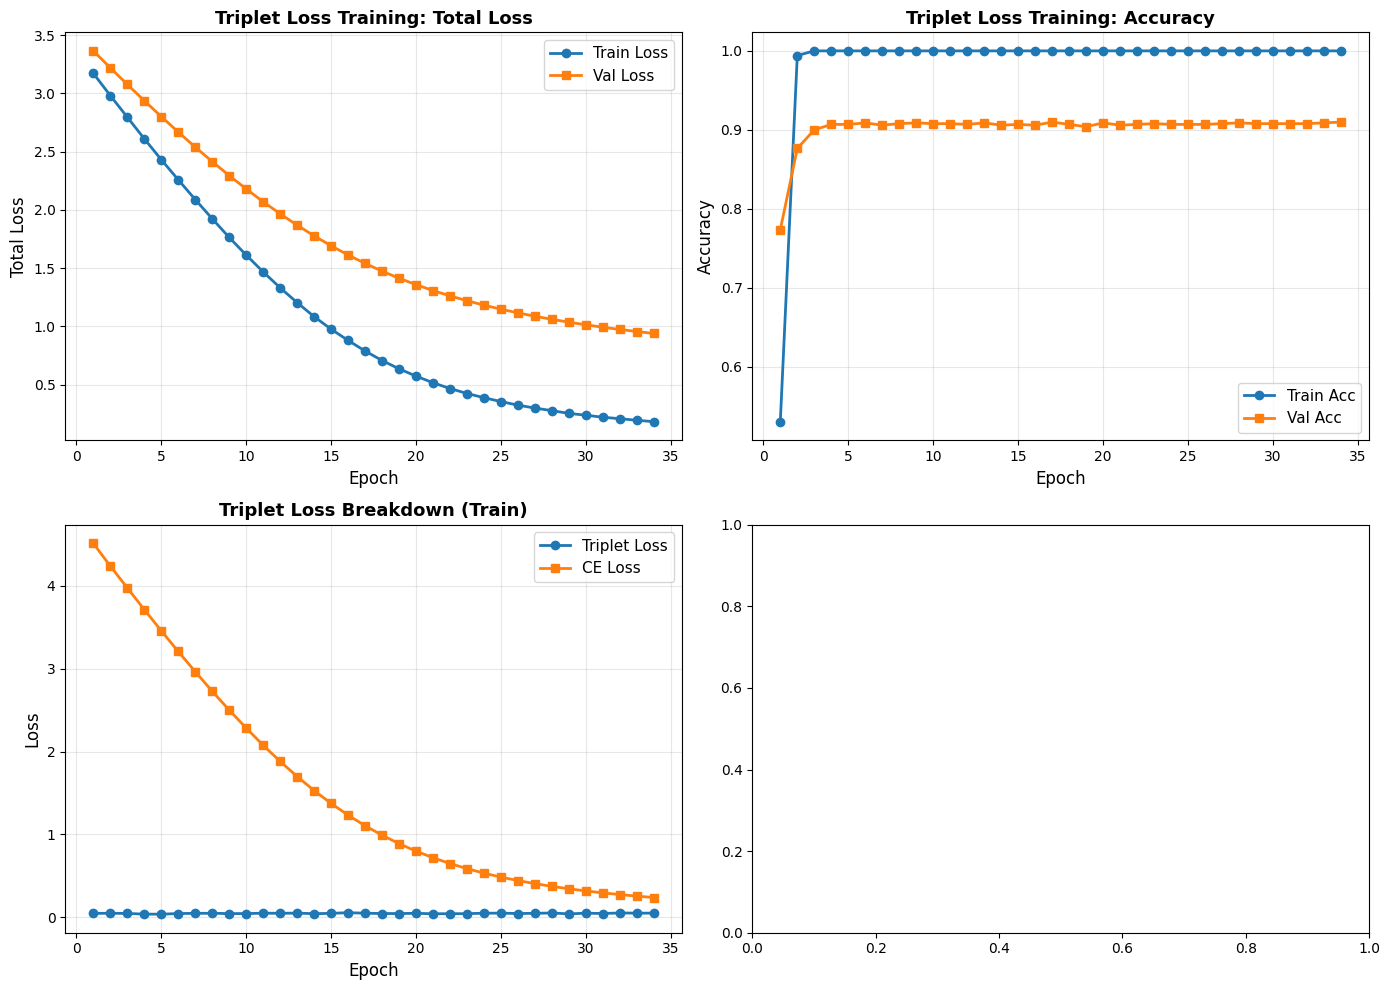

In [ ]:
import matplotlib.pyplot as plt
# Visualize results
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

epochs_range = range(1, len(train_losses_triplet) + 1)

# Loss comparison
axes[0, 0].plot(epochs_range, train_losses_triplet, 'o-', label='Train Loss', linewidth=2)
axes[0, 0].plot(epochs_range, val_losses_triplet, 's-', label='Val Loss', linewidth=2)
axes[0, 0].set_xlabel('Epoch', fontsize=12)
axes[0, 0].set_ylabel('Total Loss', fontsize=12)
axes[0, 0].set_title('Triplet Loss Training: Total Loss', fontsize=13, fontweight='bold')
axes[0, 0].grid(True, alpha=0.3)
axes[0, 0].legend(fontsize=11)

# Accuracy comparison
axes[0, 1].plot(epochs_range, train_accs_triplet, 'o-', label='Train Acc', linewidth=2)
axes[0, 1].plot(epochs_range, val_accs_triplet, 's-', label='Val Acc', linewidth=2)
axes[0, 1].set_xlabel('Epoch', fontsize=12)
axes[0, 1].set_ylabel('Accuracy', fontsize=12)
axes[0, 1].set_title('Triplet Loss Training: Accuracy', fontsize=13, fontweight='bold')
axes[0, 1].grid(True, alpha=0.3)
axes[0, 1].legend(fontsize=11)

# Loss breakdown: Triplet vs CE
axes[1, 0].plot(epochs_range, triplet_losses_triplet, 'o-', label='Triplet Loss', linewidth=2)
axes[1, 0].plot(epochs_range, ce_losses_triplet, 's-', label='CE Loss', linewidth=2)
axes[1, 0].set_xlabel('Epoch', fontsize=12)
axes[1, 0].set_ylabel('Loss', fontsize=12)
axes[1, 0].set_title('Triplet Loss Breakdown (Train)', fontsize=13, fontweight='bold')
axes[1, 0].grid(True, alpha=0.3)
axes[1, 0].legend(fontsize=11)


plt.tight_layout()
plt.show()
